# Drug Review Sentiment Analysis

<img src="header/de_header.jpg"  width="400"/>

---

*The following information was taken from the UCI Machine Learning Repository*. The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The data is split into a train (75%) a test (25%) partition and stored in two .tsv files. The data sets both have the following features:
1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful



**Citation Requested by UCI**: Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125.

---

The purpose of this project will be to ...


#### Import Libraries

In [ ]:
!pip3 install --upgrade tensorflow

In [2]:
!pip install seaborn --upgrade # update from 0.10.0 to 0.11.1

In [ ]:
pip install -U sagemaker # update sagemaker

In [4]:
pip install tdqm

In [1]:
# Import General Libraries
import numpy as np
import pandas as pd
import time
import tqdm
import os
import platform
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'

In [ ]:
# Import TensorFlow Libraries
import tensorflow as tf

# Import SKLearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Import SageMaker Libraries
import sagemaker
from sagemaker.tensorflow import TensorFlow, TensorFlowModel

# Check Versions
print(f'TensorFlow Version: {tf.__version__}') # == 2.4.1
print(f'SageMaker Version: {sagemaker.__version__}') # == 2.35+
print(f'Python Version: {platform.python_version()}') # == 3.6.0+
print(f'Seaborn Version: {sns.__version__}') # == 0.11.1+

## Data Loading & Exploration
We want to read in data from the UCI archive directly since we are using SageMaker. For convenience, we will extract the files and move them into a new subdirectory, as well as deleting the original zip file.

In [2]:
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
!unzip -o drugsCom_raw.zip

--2021-05-05 19:32:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  43.6MB/s    in 0.9s    

2021-05-05 19:32:40 (43.6 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [4]:
data_dir = 'raw_data'
if not(os.path.exists(data_dir)):
    os.mkdir(data_dir)

os.rename('drugsComTest_raw.tsv', f'{data_dir}/drugsComTest_raw.tsv')
os.rename('drugsComTrain_raw.tsv', f'{data_dir}/drugsComTrain_raw.tsv')
os.remove('drugsCom_raw.zip')

In [5]:
train = pd.read_csv(f'{data_dir}/drugsComTrain_raw.tsv', sep = '\t')
test = pd.read_csv(f'{data_dir}/drugsComTest_raw.tsv', sep = '\t')

In [8]:
train.drop('Unnamed: 0', axis=1, inplace=True) # unique id (not needed)
train.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [9]:
len(train) # original length

161297

### Drop Missing and Unrelated Values

Now that we have the data read in we will want to drop any missing or unrelated values within the dataset.

In [10]:
train.isna().sum()

drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [11]:
train = train[train.condition.notna()].reset_index()

In [12]:
train[train.condition.str.contains('</span>')].head()

,index,drugName,condition,review,rating,date,usefulCount
104,105,Loestrin 24 Fe,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f...",3.0,"November 3, 2010",2
194,196,Provera,4</span> users found this comment helpful.,"""I&#039;m 24 years old and have always had a p...",1.0,"March 27, 2016",4
241,243,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3.0,"June 1, 2010",3
262,264,Loestrin 24 Fe,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con...",2.0,"June 24, 2014",4
389,391,Norco,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger...",9.0,"March 15, 2009",11


In [15]:
idx_drop = train[train.condition.str.contains('</span>')].index.values
train.drop(train.index[idx_drop], inplace=True)
train[train.condition.str.contains('</span>')] # no values found

,index,drugName,condition,review,rating,date,usefulCount


In [16]:
len(train)

159498

After dropping the missing values and unrelated conditions, we dropped 1,799 values in total. This won't have too large of an effect since we still have around 160,000 observations that are fully complete in our dataset.

### Numerical Exploration
Two features we want to further explore in our data is `rating` and `usefulCount`. We will want to see the ratings and usefulCount distribution. We will also want to evaluate the `usefulCount` column to see if it can be related to the rating column to determine the validity of the reviews.

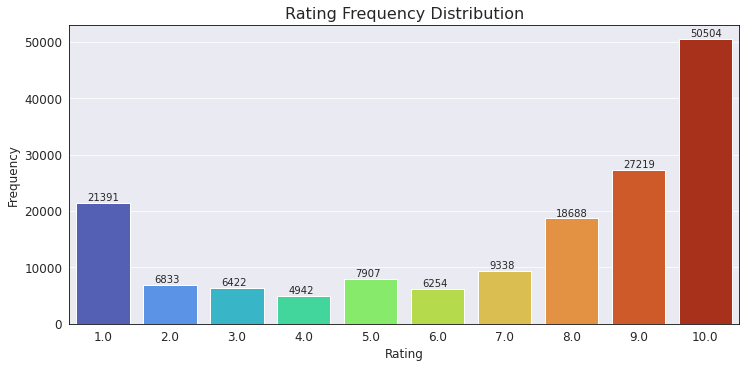

In [41]:
plt.figure(figsize=(12,5.5))
ax = sns.countplot(x='rating', data=train, palette=sns.color_palette("turbo", 10))
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title('Rating Frequency Distribution')

for i in ax.patches:
    ax.text(i.get_x()+0.17, i.get_height()+400, str(round(i.get_height(), 2)), fontsize=10) 

plt.show();

There seems to be a majority of the reviews on the positive side (8-10) compared to the neutral (4-7) or negative (1-3) sides. This could lead to a class imbalance is we use the rating column as our labels (seperated into 3 categories), so we may want to undersample in order to balance all classes. We will want to first covert the rating into sentiment values based on the above ranges, and then undersample to match the all classes to the smallest class number of observations.

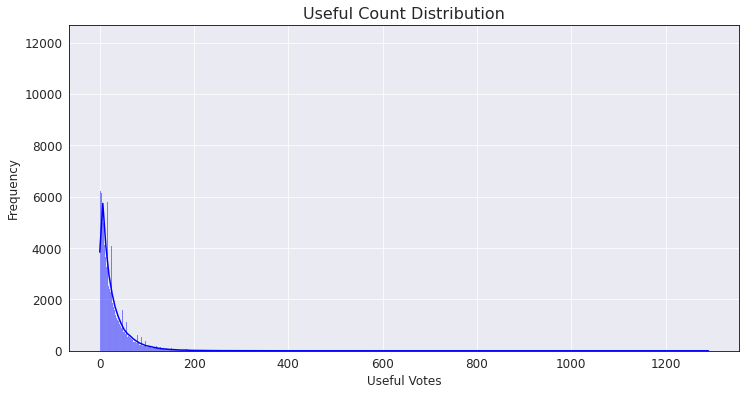

In [42]:
plt.figure(figsize=(12,6))
sns.histplot(x='usefulCount', data=train, kde=True, color='blue')
plt.xlabel('Useful Votes')
plt.ylabel('Frequency')
plt.title('Useful Count Distribution')
plt.show();

In [43]:
np.percentile(train.usefulCount, 99) # 99% of the data is below 167 votes

167.0

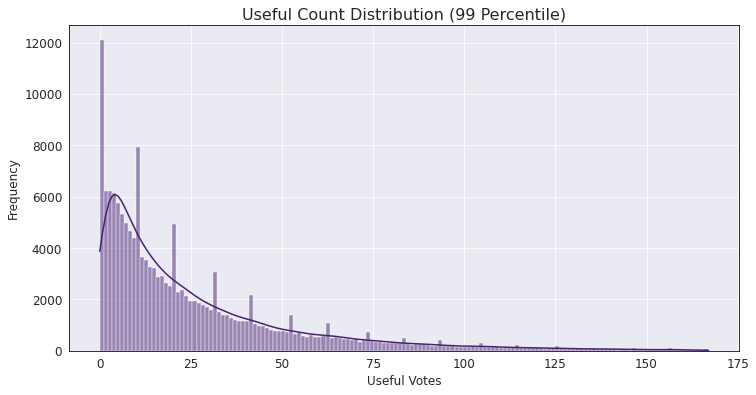

In [44]:
subset_99 = train[train.usefulCount <= 167]
plt.figure(figsize=(12,6))
sns.histplot(x='usefulCount', data=subset_99, kde=True)
plt.xlabel('Useful Votes')
plt.ylabel('Frequency')
plt.title('Useful Count Distribution (99 Percentile)')
plt.show();

We seem to have an extreme right skew in the `usefulCount` feature. The 99 percentile was 167, and even the graph for this subset of values had a right skew. Although the usefulCount value does not effect our rating, it could be considered in the validity of the review. But with extreme values over the 99% percentile we need to be careful to not allow them to effect the sentiment value if we decide to use it.

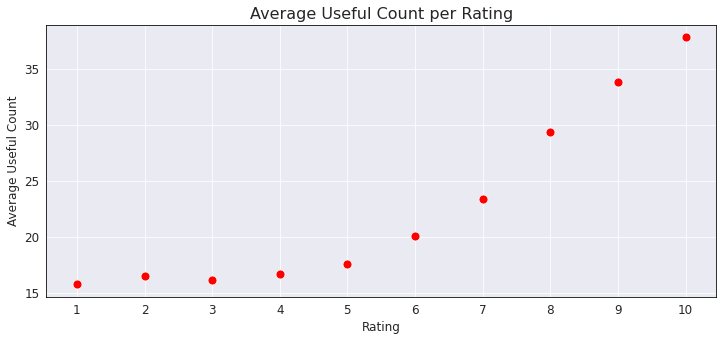

In [45]:
rate_useful = train.groupby('rating').agg('sum').usefulCount / train.groupby('rating').agg('count')['index']
plt.figure(figsize=(12,5))
sns.scatterplot(x=rate_useful.index, y=rate_useful.values, s=80, color='red')
plt.xlabel('Rating')
plt.xticks(np.arange(1,11))
plt.ylabel('Average Useful Count')
plt.title('Average Useful Count per Rating')
plt.show();

It seems that the average `usefulCount` votes increases as the rating increases. This could be an indicator that the positive reviews could be more reliable than the negative reviews, or just a fact that people seemed to have less negative effects and therefore did not vote for a negative review. We will want to keep this in mind when creating our data (is the rating given truely reliable?).

### Categorical Exploration

Three of the categorical features we will want to explore are `condition`, `drugName`, and `date`. We won't go to far into depth for the `reviews` feature, but we will want to look at the top 10 most common conditions (as well as the top 10 drugs administered for the top condition), the top 10 most common drugs and their use cases, and a distribution of the dates (yearly and monthly).

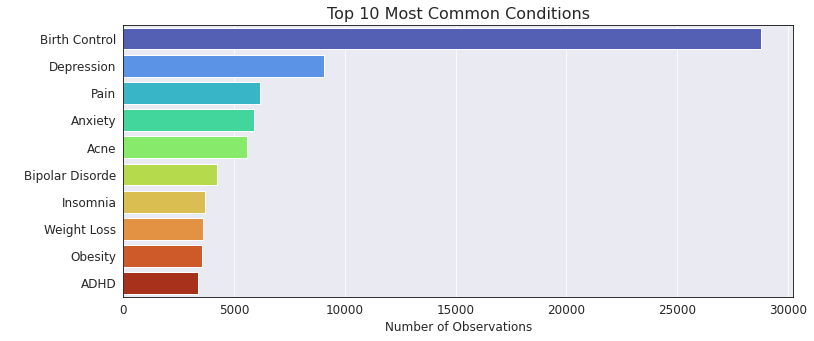

In [46]:
top10_condition = train.groupby('condition').agg('count').sort_values(by ='drugName', ascending=False)[:10]

plt.figure(figsize=(12,5))
sns.barplot(y=top10_condition['index'].index, x=top10_condition['index'].values, palette=sns.color_palette("turbo", 10))
plt.xlabel('Number of Observations')
plt.ylabel(' ')
plt.title('Top 10 Most Common Conditions')
plt.show();

Birth control seems to be the most common condition by at least 3x, followed by Depression and Pain. These conditions related to perscription drugs are expected and there was no suprises in the findings. We may want to look at the distribution of `drugName` for Birth control to better understand the observations.

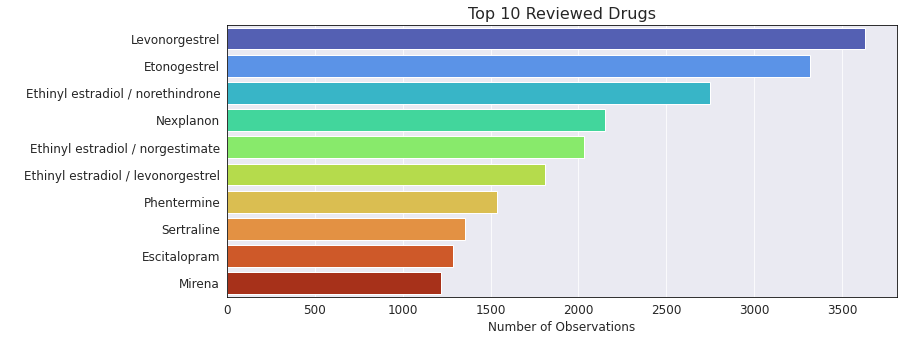

In [48]:
top_drugs = train.groupby('drugName').agg('count').sort_values(by ='review', ascending=False)[:10]
plt.figure(figsize=(12,5))
sns.barplot(y=top_drugs['index'].index, x=top_drugs['index'].values, palette=sns.color_palette("turbo", 10))
plt.xlabel('Number of Observations')
plt.ylabel(' ')
plt.title('Top 10 Reviewed Drugs')
plt.show();

Looking into the drugs with most most number of reviews in our dataset, we can see the majority of them are related to birth control. This is also expected given that the majority of the conditions in our dataset are Birth Control.

In [52]:
train['date'] = pd.to_datetime(train.date)
train['year'] = train['date'].dt.year

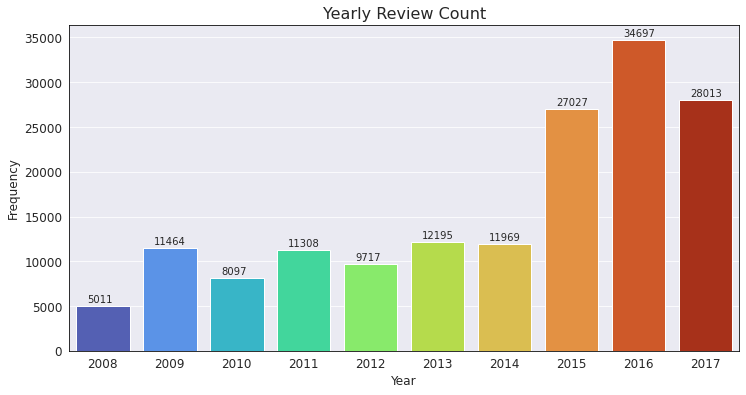

In [56]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x='year', data=train, palette=sns.color_palette("turbo", 10))
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_title('Yearly Review Count')

for i in ax.patches:
    ax.text(i.get_x()+0.17, i.get_height()+400, str(round(i.get_height(), 2)), fontsize=10) 
    
plt.show();

It seems that the last 3 years in the dataset (2015-2017) hold the majority of the reviews. It seemed to be steady from 2009-2014, and then more than doubling in 2015-2017. We may want to look into what caused this spike, or what the average review is each year to see if more reviews leads to a higher average?

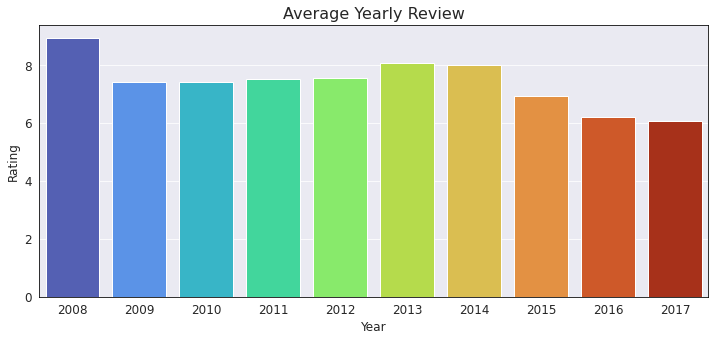

In [55]:
yearly_rating = train.groupby('year').agg('sum')['rating'] / train.groupby('year').agg('count')['date']

plt.figure(figsize=(12,5))
sns.barplot(x = yearly_rating.index, y = yearly_rating.values, palette=sns.color_palette("turbo", 10))
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average Yearly Review')
plt.show();

It does not seem that the reviews were increasing as more were recorded, rather the opposite. For 2008, it had the lowest number of total reviews yet it had the highest average. For 2016, it had the highest total reviews yet it had almost the lowest average rating (very close to 2017 which had the lowest). This could mean that more reviews could correlate to more negative reviews?

## Data Processing (Training & Testing)

Now that we have explored the data, we will want to process it in order to be prepared for use in our model. This includes both the training and testing sets. We will reload both *.tsv* files (in order to apply the same function to both). We will:
- Remove any missing values.
- Remove any unusual conditions (some conditions describe useful count).
- Create new feature for sentiment based on rating (see rating exploration for range descriptions).
- Format *review* so that it can be used in a RNN.
- Upload data to S3 after being processed.

In [60]:
train = pd.read_csv(f'{data_dir}/drugsComTrain_raw.tsv', sep = '\t')
test = pd.read_csv(f'{data_dir}/drugsComTest_raw.tsv', sep = '\t')

In [59]:
def initial_data_processing(data):
    '''
    Function used to format data frame by removing missing values, dropping any
    unnecessary features, creating sentiment feature based on rating, and
    return a cleaned data frame.
    '''
    data.drop('Unnamed: 0', axis=1, inplace=True) # unique id (not needed)
    
    # to be filled in...
    
    return data